In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [85]:
# Link: https://www.kaggle.com/datasets/datamunge/sign-language-mnist

train = pd.read_csv('../data/sign_mnist_train.csv')
test = pd.read_csv('../data/sign_mnist_test.csv')

In [86]:
images, labels = train.iloc[:, 1:], train['label']
test_images, test_labels = test.iloc[:, 1:], test['label']

In [87]:
labels = to_categorical(labels, num_classes=25)
test_labels = to_categorical(test_labels, num_classes=25)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=42)

In [89]:
# Scales the pixel values from the original range of 0 to 255 to a normalized range between 0 and 1.
# Trains faster and improves overall performance.
X_train = X_train.values / 255.0
X_test = X_test.values / 255.0
test_images = test_images.values / 255.0

In [90]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

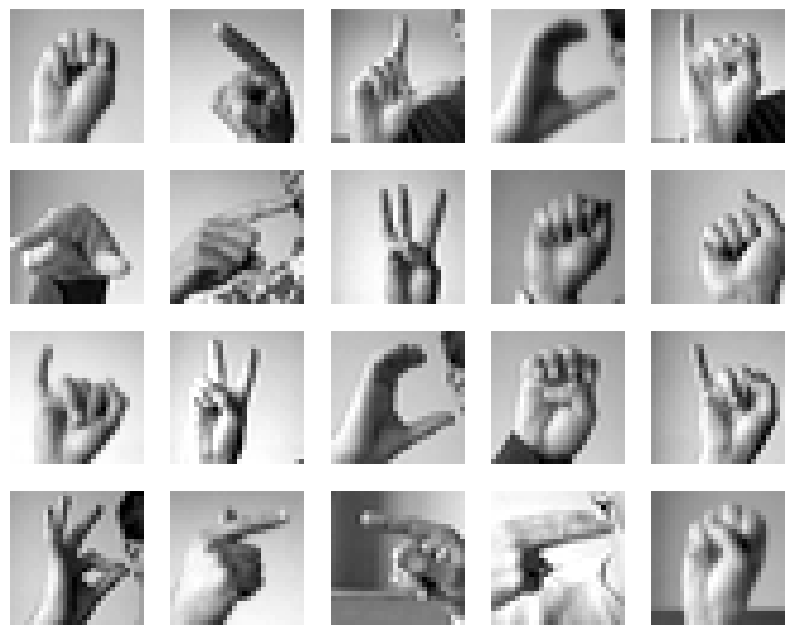

In [91]:
plt.figure(figsize=(10, 8))

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i], cmap="grey")
    plt.axis("off")

plt.savefig("../images/variations.png", bbox_inches="tight")

In [92]:
X_train[0].shape

(28, 28, 1)

In [93]:
image_generator = ImageDataGenerator(
    rotation_range = 15,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
)

test_generator = ImageDataGenerator()

gen_train = image_generator.flow(X_train, y_train, batch_size = 128)
gen_valid = test_generator.flow(X_test, y_test, batch_size = 128)
gen_test = test_generator.flow(test_images, test_labels, batch_size = 128)

In [94]:
model = Sequential()

model.add(Conv2D(32, 3, activation="relu", padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(2))

model.add(Conv2D(64, 3, activation="relu", padding='same',))
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 3, activation="relu", padding='same',))
model.add(MaxPooling2D(2))

model.add(Conv2D(256, 3, activation="relu", padding='same',))
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(512, activation="relu"))

model.add(Dense(25, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(
    patience=3, monitor="val_loss", restore_best_weights=True
)

history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
161/161 [==============================] - 7s 39ms/step - loss: 2.7681 - acc: 0.1579 - val_loss: 1.8754 - val_acc: 0.3529
Epoch 2/20
161/161 [==============================] - 6s 38ms/step - loss: 1.4290 - acc: 0.5077 - val_loss: 0.7223 - val_acc: 0.7223
Epoch 3/20
161/161 [==============================] - 6s 38ms/step - loss: 0.8486 - acc: 0.7048 - val_loss: 0.5590 - val_acc: 0.7851
Epoch 4/20
161/161 [==============================] - 6s 38ms/step - loss: 0.5824 - acc: 0.7996 - val_loss: 0.2219 - val_acc: 0.9167
Epoch 5/20
161/161 [==============================] - 6s 39ms/step - loss: 0.4363 - acc: 0.8461 - val_loss: 0.1770 - val_acc: 0.9309
Epoch 6/20
161/161 [==============================] - 6s 39ms/step - loss: 0.3360 - acc: 0.8820 - val_loss: 0.0957 - val_acc: 0.9655
Epoch 7/20
161/161 [==============================] - 6s 38ms/step - loss: 0.2453 - acc: 0.9181 - val_loss: 0.0677 - val_acc: 0.9770
Epoch 8/20
161/161 [==============================] - 6s 39ms/step - 

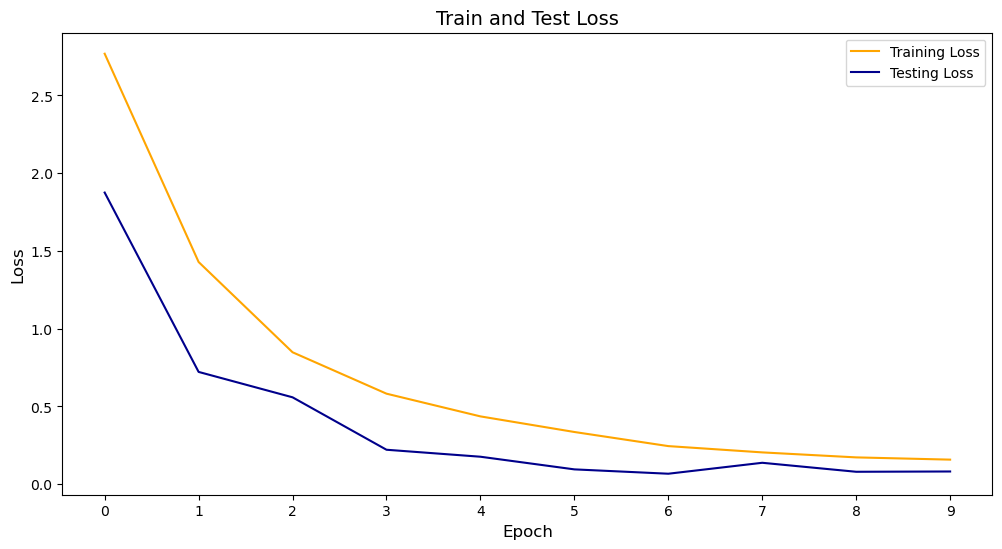

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], c="orange", label="Training Loss")
plt.plot(history.history["val_loss"], c="darkblue", label="Testing Loss")

x_ticks = [i for i in range(0, len(history.history["loss"]), 1)]
plt.xticks(x_ticks, x_ticks)

plt.title("Train and Test Loss", size=14)
plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.legend()
plt.savefig("../images/train_test_loss.png", bbox_inches="tight")

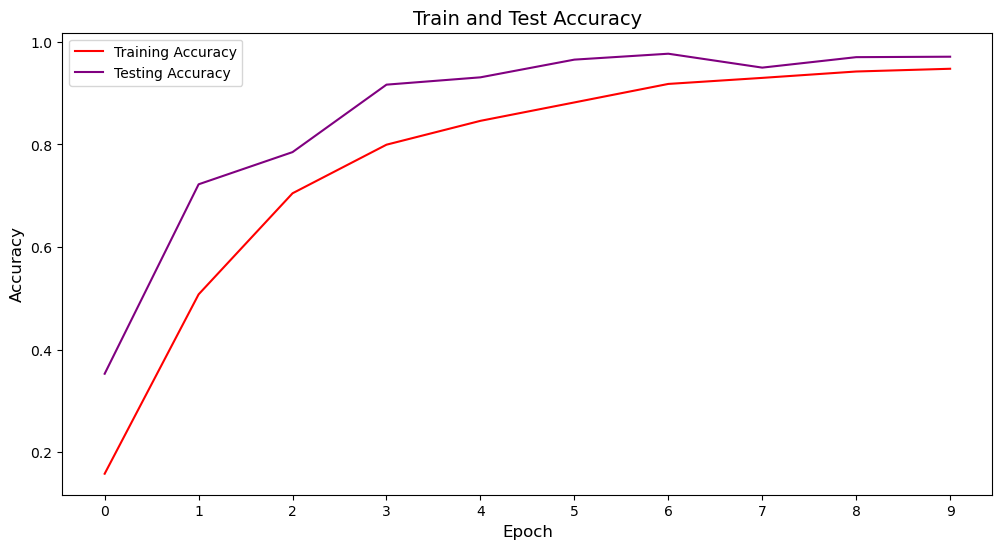

In [96]:
plt.figure(figsize=(12, 6))

plt.plot(history.history["acc"], c="red", label="Training Accuracy")
plt.plot(history.history["val_acc"], c="purple", label="Testing Accuracy")

x_ticks = [i for i in range(0, len(history.history["loss"]), 1)]
plt.xticks(x_ticks, x_ticks)

plt.title("Train and Test Accuracy", size=14)
plt.xlabel("Epoch", size=12)
plt.ylabel("Accuracy", size=12)
plt.legend()
plt.savefig("../images/train_test_acc.png", bbox_inches="tight")

In [97]:
testAcc = model.evaluate(gen_test)[1] * 100
trainAcc = model.evaluate(gen_train)[1] * 100
print(f'Testing accuracy of model : {testAcc:.2f}%')
print(f'Training accuracy of model : {trainAcc:.2f}%')

161/161 [==============================] - 5s 29ms/step - loss: 0.1910 - acc: 0.9356
Testing accuracy of model : 97.14%
Training accuracy of model : 93.56%


In [98]:
# Save model
model.save("../data/model.h5")

c:\Users\Landr\anaconda3\envs\env_full\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
